In [1]:
# imports
import sys
import pandas as pd
sys.path.append('../../') # to access the files in higher directories
sys.path.append('../') # to access the files in higher directories
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import core_exp as cx
import core_calib as cal

In [2]:
params = {
    # exp
    "seed": 0,
    "runs": 1,
    "exp_name": "Trees",
    "cv_folds": 10,
    "plot": True,
    "calib_methods": ["RF", 
                      "Platt", "ISO", "Beta", "CRF",
                     ],
    "metrics": ["acc", "tce", "logloss", "brier", "ece", "auc"],
    
    #data
    "data_name": "synthetic",
    "plot_data": True,
    "data_size": 1000,
    "n_features": 2,

    "class1_mean_min":0, 
    "class1_mean_max":1,
    "class2_mean_min":1, 
    "class2_mean_max":3, 

    # calib param
    "bin_strategy": "uniform",
    "ece_bins": 20,
    "boot_size": 5000,
    "boot_count": 40,

    "opt_cv":5, 
    "opt_n_iter":40,
    "opt_top_K": 5,
    "search_space": {
                    "n_estimators": [10],
                    "max_depth": [2,3,4,5,6,7,8,10,15,20,30,40,50,60,100],
                    "criterion": ["gini", "entropy"],
                    "max_features": ["sqrt", "log2"],
                    "min_samples_split": [2,3,4,5],
                    "min_samples_leaf": [1,2,3],
                    },

    # RF hyper opt
    "hyper_opt": "Manual",
    "depth": 4,
}
exp_key = "n_estimators"
exp_values = [1,2,3,4,5,10,20,50,100,200,500]

In [3]:
calib_results_dict, data_list = cx.run_exp(exp_key, exp_values, params)
tables = cal.mean_and_ranking_table(calib_results_dict, 
                                    params["metrics"], 
                                    params["calib_methods"], 
                                    data_list, 
                                    mean_and_rank=True, 
                                    std=True)

In [4]:
print(params["calib_methods"][tables["tce"].loc["Rank"].argmin()])
tables["tce"]

RF


,RF,Platt,ISO,Beta,CRF
Data,,,,,
1,0.030157,0.025328,0.027672,0.029085,0.030614
2,0.019809,0.021054,0.024838,0.022610,0.020439
3,0.014616,0.015450,0.022375,0.016658,0.015883
4,0.010127,0.011026,0.018973,0.011667,0.012913
5,0.008259,0.009237,0.016450,0.010006,0.009561
10,0.005906,0.007275,0.012795,0.008010,0.006790
20,0.005074,0.006450,0.011768,0.007125,0.005480
50,0.004263,0.005526,0.011190,0.006030,0.004781
100,0.003706,0.005234,0.010434,0.005856,0.003919


In [5]:
print(params["calib_methods"][tables["brier"].loc["Rank"].argmin()])
tables["brier"]

RF


,RF,Platt,ISO,Beta,CRF
Data,,,,,
1,0.168201,0.165594,0.172578,0.168099,0.169163
2,0.160517,0.162029,0.168973,0.162441,0.162081
3,0.156085,0.157483,0.163872,0.157719,0.158209
4,0.153100,0.154556,0.160210,0.154117,0.156614
5,0.149879,0.151498,0.157226,0.150846,0.151321
10,0.147825,0.150056,0.153050,0.149683,0.149178
20,0.146657,0.148733,0.153817,0.147987,0.147860
50,0.145410,0.147404,0.152503,0.146639,0.146077
100,0.145073,0.147304,0.152393,0.146726,0.145489


In [6]:
plot_calib_methods = params["calib_methods"].copy()
# plot_calib_methods.remove("Rank")
# plot_calib_methods.remove("Elkan")
# plot_calib_methods.remove("RF")
plot_calib_methods

['RF', 'Platt', 'ISO', 'Beta', 'CRF']

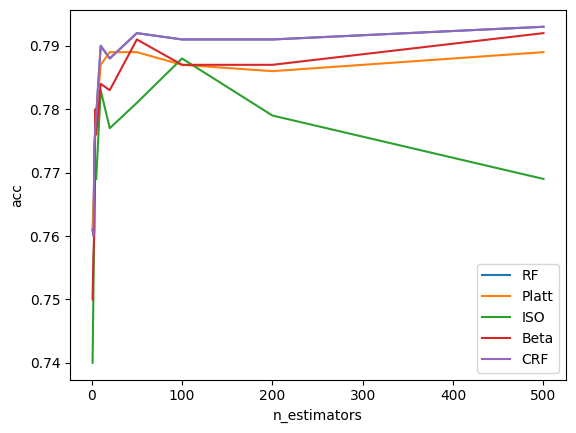

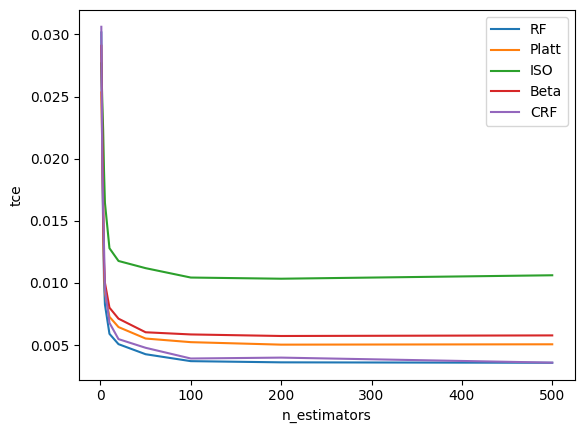

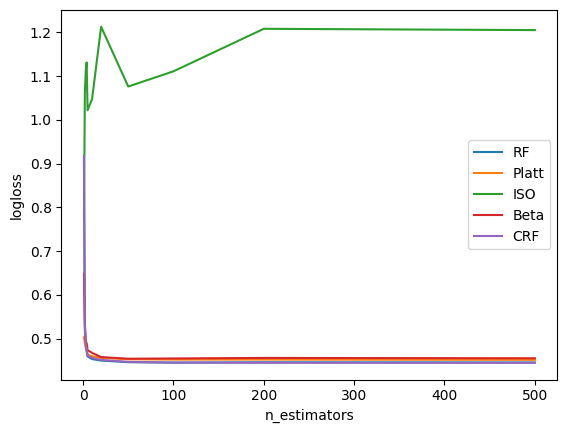

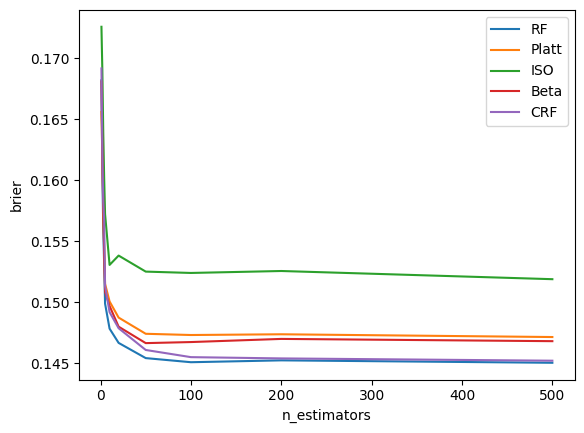

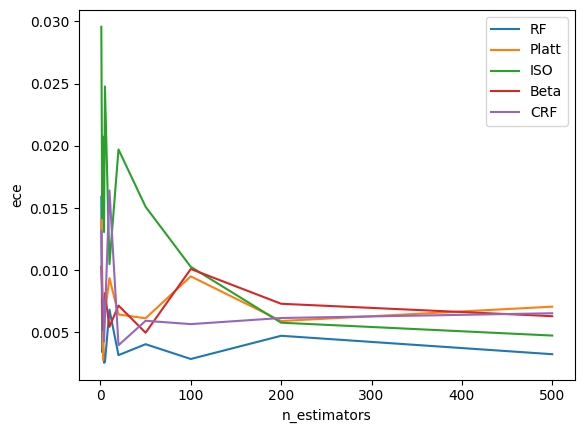

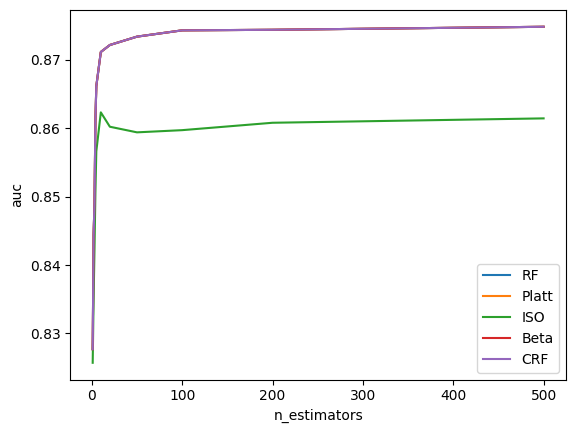

In [7]:
tables = cal.mean_and_ranking_table(calib_results_dict, 
                                    params["metrics"], 
                                    params["calib_methods"], 
                                    data_list, 
                                    mean_and_rank=False, 
                                    std=True)
for metric in params["metrics"]:
    ax = tables[metric][plot_calib_methods].plot()
    ax.set_xlabel(exp_key)
    ax.set_ylabel(metric)